In [1]:
!pip install git+https://github.com/ficstamas/FateML.git
!pip install --upgrade scikit-learn~=1.2.1

import matplotlib.pyplot as plt
%matplotlib inline

  Cloning https://github.com/ficstamas/FateML.git to c:\users\ftkni\appdata\local\temp\pip-req-build-31ei49ea
  Resolved https://github.com/ficstamas/FateML.git to commit 3017796011a79dffdc068a6a23c6a0b7a378ad84
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ficstamas/FateML.git 'C:\Users\ftkni\AppData\Local\Temp\pip-req-build-31ei49ea'


# Model-Agnostic interpretation and explonation

So far, we have looked at intrinsically interpretable models. These models provide insight into their decision-making process and designed to be easily understood by humans through visual representation. The interpretation methods are usually model specific and can not be used among different architectures.


On the otherhand, __model-agnostic methods seprate the interpretation from the machine learning model__, making it flexible to use and allowing the user to compare different types of models. There are 3 desired aspects for an agnostic method:
- __Model flexibility__, which means it can work with any machine learning model. (e.g. linear regression, random forests, neural models)
- __Explanation flexibility__, which means it is not limited to one type fo explanation. (e.g. linear formulas, graphical explanation)
- __Representation flexibility__, which means it can handle different type of features. (e.g. numerical, categorical, time series, words)


Model-agnostic methods can be differentiated into:
- __local methods__, which explain individual predictions, and
- __global methods__, which explain the effect of features on predictions on average

# Global Methods

## Partial Dependence Plots (PDP)

Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features. Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

The partial dependence function for regression is defined as:
$$F(x_s)=\frac{1}{n}\sum^n_{i=1}f(x_s, x_c),$$
where $x_s$ contains the perturbed feature values (usually for 1 or 2 features) and $x_c$ defines the real (unchanged) features.

In [2]:
from fateml.data import load_dataset

diabetes = load_dataset("diabetes", standardize=False, statsmodels_format=False, scaled=False)

In [3]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor(random_state=0)
reg.fit(diabetes.train_x, diabetes.train_y)

C:\Users\ftkni\AppData\Local\Temp\ipykernel_8412\2912042498.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  reg.fit(diabetes.train_x, diabetes.train_y)


RandomForestRegressor(random_state=0)

### ICE (recap)

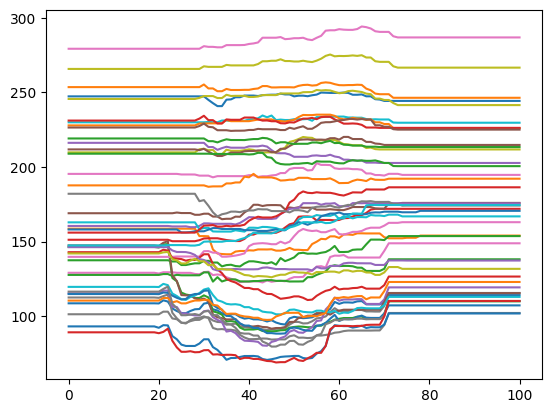

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# altering age
for i, x in diabetes.dev_x.iterrows():
    alternative = np.arange(0, 101, 1)  # possible values for age
    x_altered = np.tile(x.values, (len(alternative), 1))
    x_altered[:, 0] = alternative
    id_ = x.name
    cols = list(x.index)
    x_altered = pd.DataFrame(data=x_altered, columns=cols)
    pred = reg.predict(x_altered)
    plt.plot(alternative, pred)

### End of Recap

## PDP from ICE

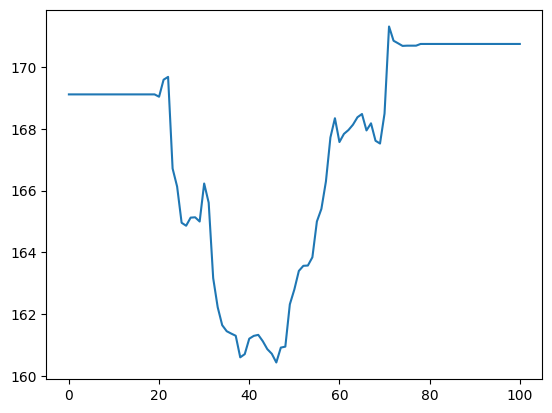

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# altering age
alternative = np.arange(0, 101, 1)  # possible values for age

# the only difference is that we are going to average it among all the samples
vec = np.zeros_like(alternative, dtype=float)

for i, x in diabetes.dev_x.iterrows():
    x_altered = np.tile(x.values, (len(alternative), 1))
    x_altered[:, 0] = alternative
    id_ = x.name
    cols = list(x.index)
    x_altered = pd.DataFrame(data=x_altered, columns=cols)
    pred = reg.predict(x_altered)
    vec += pred

plt.plot(alternative, vec / diabetes.dev_x.__len__())

Index(['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6', 'sex'], dtype='object')


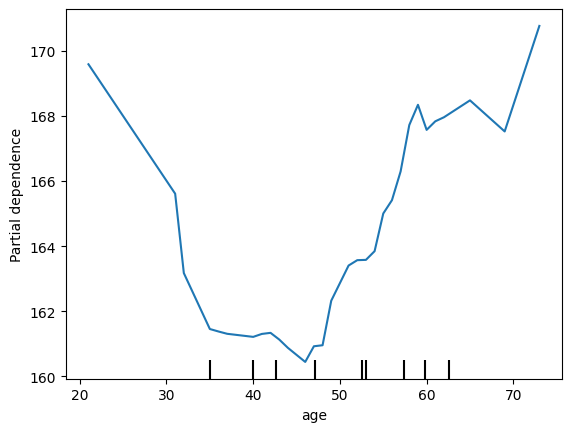

In [6]:
from sklearn.inspection import PartialDependenceDisplay

print(diabetes.train_x.columns)

PartialDependenceDisplay.from_estimator(reg, diabetes.dev_x, ['age'], method='brute')

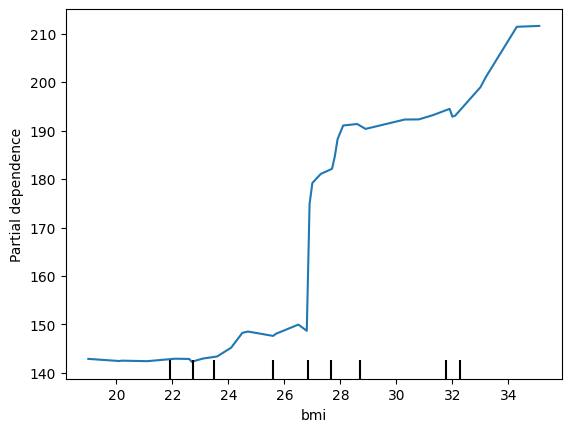

In [7]:
PartialDependenceDisplay.from_estimator(reg, diabetes.dev_x, ['bmi'], method='brute')

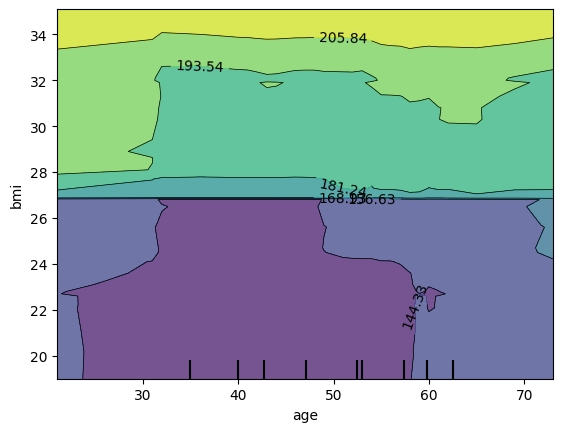

In [8]:
PartialDependenceDisplay.from_estimator(reg, diabetes.dev_x, [('age', 'bmi')], method='brute')

## PDP-based Feature importance

It was built on the assumption that the variability of the PDP line can indicate its importance. A flat PDP can indicate that the feature is not important, and a more varying PDP can indicate a more important feature. For numerican feature we can define the importance score as the deviation from the average curve:
$$I(x_S)=\sqrt{\frac{1}{K-1}\sum_{k=1}^{K}\left(\hat{f}_S(x^{(k)}_S)-\frac{1}{K}\sum_{k=1}^{K}\hat{f}_S(x^{(k)}_S)\right)^2}$$
For categorical feature:
$$I(x_S)=\left(max_k(\hat{f}_S(x^{(k)}_S))−min_k(\hat{f}_S(x^{(k)}_S))\right)/4$$

Although, this feature importance score can be useful, it should be handled with care. It can not capture feature interactions only the main effect of the feature.

In [32]:
evaluations = {}
for k in diabetes.dev_x.columns:
    unique = diabetes.dev_x[k].unique()
    pdp = []
    for u in unique:
        copy_ = diabetes.dev_x.copy()
        copy_[k] = u
        predictions = reg.predict(copy_)
        pdp.append(predictions.reshape(-1, 1))
    pdp = np.concatenate(pdp, axis=-1)
    evaluations[k] = np.mean(pdp, axis=0)  # pdp values

In [36]:
pdp_importance = {"feature": [], "score": []}
for f in evaluations:
    if f == 'sex':  # the only categorical feature
        score = (np.max(evaluations[f]) - np.min(evaluations[f]))/4
    else:  # for numerical features
        means = np.mean(evaluations[f])
        score = np.sum((evaluations[f] - means)**2) / (len(evaluations[f]) - 1)
        score = np.sqrt(score)
    pdp_importance["feature"].append(f)
    pdp_importance["score"].append(score)

<AxesSubplot:>

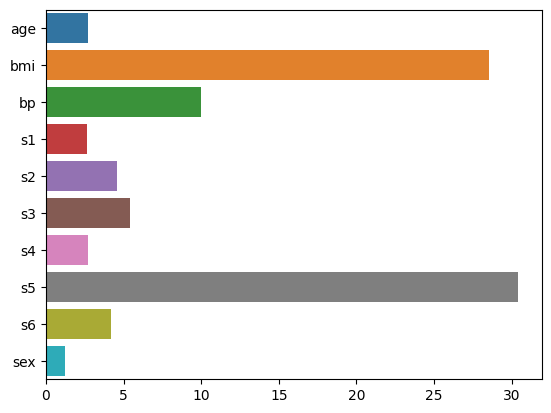

In [37]:
import seaborn as sns

sns.barplot(data=pdp_importance, x="score", y="feature", orient="h")

## Permutation Feature Importance

The basic idea behind permutation feature importance is to randomly shuffle the values of one feature at a time and measure the resulting decrease in the model's performance. If the performance of the model drops significantly after shuffling a particular feature, it suggests that the model relies heavily on that feature for making predictions.

Outline of the algorithm:
Input: Trained model $\hat{f}$, feature matrix $X$, target vector $y$, error measure $L(y,\hat{f})$
1. Estimate the original model error $e_{orig}=L(y,\hat{f}(X))$ (e.g. mean squared error)
2. For each feature $j\in\{1,\dots,p\}$ do:
   1. Repeat and calculate the average and standard deviation of each permutation ($FI_j^{(i)}$):
      1. Generate feature matrix $X_{perm}^{(i)}$ by permuting feature $j$ in the data $X$. This breaks the association between feature $j$ and true outcome $y$.
      2. Estimate error $e_{perm}^{(i)}=L(y,\hat{f}(X_{perm}^{(i)}))$ based on the predictions of the permuted data.
      3. Calculate permutation feature importance as quotient $FI_j=e_{perm}^{(i)}/e_{orig}$ or difference $FI_j=e_{perm}^{(i)}−e_{orig}$
3. Sort features by descending FI.

In [16]:
from sklearn.metrics import mean_squared_error

np.random.seed(0)

n_repeats = 100
e_orig = mean_squared_error(diabetes.dev_y, reg.predict(diabetes.dev_x))

FI = []

for j in diabetes.dev_x.columns:
    e = []
    # repeat it for better aproximation
    for _ in range(n_repeats):
        X_perm = diabetes.dev_x
        X_perm[j] = np.random.permutation(X_perm[j])
        e_perm = mean_squared_error(diabetes.dev_y, reg.predict(X_perm))
        e.append(e_perm)
    
    e = np.array(e)
    quotient = e / e_orig
    diff = e - e_orig
    FI.append([j, np.mean(quotient), np.std(quotient), np.mean(diff), np.std(diff)])

In [17]:
data = pd.DataFrame(data=FI, columns=['features', 'quotient_mean', 'quotient_std', 'diff_mean', 'diff_std'])
data

,features,quotient_mean,quotient_std,diff_mean,diff_std
0,age,1.010991,0.015431,70.993153,99.671797
1,bmi,1.268243,0.116312,1732.686295,751.301302
2,bp,1.086068,0.055805,555.947922,360.468386
3,s1,0.966468,0.016577,-216.594200,107.074651
4,s2,0.984633,0.021810,-99.259243,140.878875
5,s3,1.007333,0.021103,47.365473,136.311308
6,s4,0.999759,0.012755,-1.553901,82.389494
7,s5,0.911303,0.109385,-572.925141,706.557688
8,s6,0.859339,0.016649,-908.582916,107.541596
9,sex,0.879202,0.011672,-780.278010,75.396486


<ErrorbarContainer object of 3 artists>

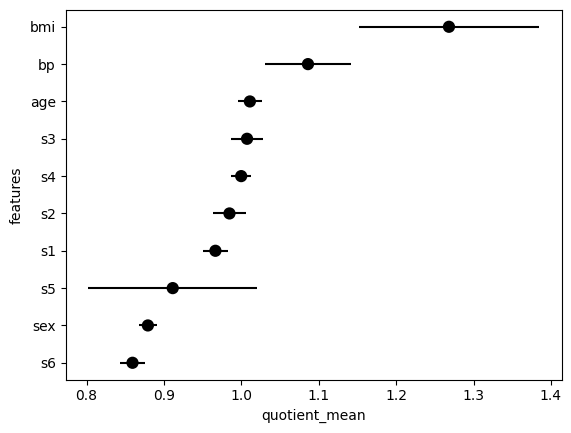

In [18]:
import seaborn as sns

sorted_ = data.sort_values(by=['quotient_mean'], ascending=False)
sns.pointplot(data=sorted_, x="quotient_mean", y="features", orient="h", join=False, color='black')
plt.errorbar(y=np.arange(len(data)), x=sorted_["quotient_mean"], xerr=sorted_["quotient_std"], fmt='none', c='black')

<ErrorbarContainer object of 3 artists>

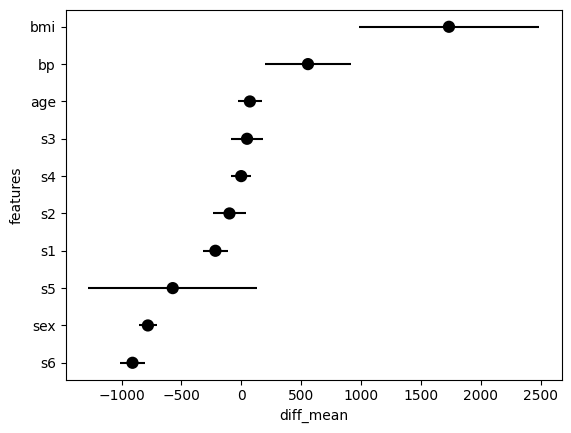

In [19]:
sorted_ = data.sort_values(by=['diff_mean'], ascending=False)
sns.pointplot(data=sorted_, x="diff_mean", y="features", orient="h", join=False, color='black')
plt.errorbar(y=np.arange(len(data)), x=sorted_["diff_mean"], xerr=sorted_["diff_std"], fmt='none', c='black')